##Import libraries 📚

In [ ]:
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab import files # upload data
import io
from termcolor import colored#color
from sklearn.preprocessing import LabelEncoder #gán nhãn
from sklearn.preprocessing import StandardScaler #scale data
from sklearn import preprocessing

# **Random forest from scratch** 🌳

Chia dữ liệu thành một tập huấn luyện và thử nghiệm để có thể xác nhận hiệu suất của các mô hình

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

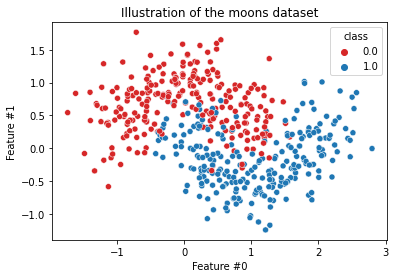

In [ ]:
feature_names = ["Feature #0","Feature #1"]
target_name = "class"
# We store both the data and target in a dataframe to ease plotting
moons = pd.DataFrame(np.concatenate([X, y[:, np.newaxis]], axis=1),columns=feature_names + [target_name])
data_moons, target_moons = moons[feature_names], moons[target_name]
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=moons, x=feature_names[0], y=feature_names[1],
                hue=target_moons, palette=["tab:red", "tab:blue"])
_ = plt.title("Illustration of the moons dataset")

In [ ]:
# use model.fit
# Impute our data, then train
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
# Impute test item, then predict
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train,y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

100.0

Công cụ đo lường được sử dụng nhiều nhất để xây dựng cây quyết định nhị phân là: Entropy, độ lỗi phân loại và hệ số Gini. Ở đây chúng ta sẽ tập trung vào Entropy, là một đại lượng đo lường sự không chắc chắn (đôi khi còn gọi là sự hỗn tạp)

Xác định hàm entropy và information_gain sẽ giúp tìm ra điểm phân tách tốt nhất

In [ ]:
def entropy(p):
    if p == 0:
        return 0
    elif p == 1:
        return 0
    else:
        return - (p * np.log2(p) + (1 - p) * np.log2(1-p))    
    
def information_gain(left_child, right_child):
    parent = left_child + right_child
    p_parent = parent.count(1) / len(parent) if len(parent) > 0 else 0
    p_left = left_child.count(1) / len(left_child) if len(left_child) > 0 else 0
    p_right = right_child.count(1) / len(right_child) if len(right_child) > 0 else 0
    IG_p = entropy(p_parent)
    IG_l = entropy(p_left)
    IG_r = entropy(p_right)
    return IG_p - len(left_child) / len(parent) * IG_l - len(right_child) / len(parent) * IG_r

Trong hàm trên entropy nhận vào một xác suất của một lớp bên trong một nút và information_gain nhận trong danh sách các lớp từ phần con bên trái và bên phải và trả về mức tăng thông tin của phần tách cụ thể đó.

Sau đó chúng ta sẽ xác định một hàm draw_bootstrap có thể nhận đầu vào là dữ liệu huấn luyện (X_train) ở dạng dataframe và đầu ra ở dạng mảng. Chúng ta sẽ yêu cầu nó trả về bootstrap đã lấy mẫu X_boot và y_boot và chúng ta sẽ sử dụng nó để xây dựng một cây.

Chúng ta cũng sẽ trả lại các kết quả quan sát trong túi đã bị bỏ qua để đào tạo gọi là X_oob và y_oob. Tại mỗi lần lặp mới, sử dụng các mẫu OOB để đánh giá hiệu suất của cây được xây dựng bằng bootstrapped data.

In [ ]:
def draw_bootstrap(X_train, y_train):
    bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
    oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
    X_bootstrap = X_train[bootstrap_indices]
    y_bootstrap = y_train[bootstrap_indices]
    X_oob = X_train[oob_indices]
    y_oob = y_train[oob_indices]
    return X_bootstrap, y_bootstrap, X_oob, y_oob

def oob_score(tree, X_test, y_test):
    mis_label = 0
    for i in range(len(X_test)):
        pred = predict_tree(tree, X_test[i])
        if pred != y_test[i]:
            mis_label += 1
    return mis_label / len(X_test)

Tiếp theo, chúng ta sẽ hiện thực hàm find_split_point theo cách bước:

1.  Chọn m feature ngẫu nhiên
2.  Với mỗi feature đã chọn  lặp lại qua từng giá trị trong tập dữ liệu khởi động và tính toán mức tăng thông tin(information gain)
3. Trả về một từ điển sẽ đại diện cho một nút trong một cây có chứa:

    - Feature index

    - Giá trị để phân chia tại

    - Nút con bên trái

    - Nút con bên phải

được tạo ra từ điểm phân tách với mức information gain cao nhất. Điều quan trọng cần lưu ý là mỗi nút con sẽ được lưu trữ dưới dạng danh sách các phần tử (element), mà mỗi phần tử là một cặp khóa và giá trị với đầu vào X_bootstrap và kết quả đầu ra y_bootstrap

In [ ]:
def find_split_point(X_bootstrap, y_bootstrap, max_features):
    feature_ls = list()
    num_features = len(X_bootstrap[0])
    
    while len(feature_ls) <= max_features:
        feature_idx = random.sample(range(num_features), 1)
        if feature_idx not in feature_ls:
            feature_ls.extend(feature_idx)
    
    best_info_gain = -999
    node = None
    for feature_idx in feature_ls:
        for split_point in X_bootstrap[:,feature_idx]:
            left_child = {'X_bootstrap': [], 'y_bootstrap': []}
            right_child = {'X_bootstrap': [], 'y_bootstrap': []}
            
            # split children for continuous variables
            if type(split_point) in [int, float]:
                for i, value in enumerate(X_bootstrap[:,feature_idx]):
                    if value <= split_point:
                        left_child['X_bootstrap'].append(X_bootstrap[i])
                        left_child['y_bootstrap'].append(y_bootstrap[i])
                    else:
                        right_child['X_bootstrap'].append(X_bootstrap[i])
                        right_child['y_bootstrap'].append(y_bootstrap[i])
            # split children for categoric variables
            else:
                for i, value in enumerate(X_bootstrap[:,feature_idx]):
                    if value == split_point:
                        left_child['X_bootstrap'].append(X_bootstrap[i])
                        left_child['y_bootstrap'].append(y_bootstrap[i])
                    else:
                        right_child['X_bootstrap'].append(X_bootstrap[i])
                        right_child['y_bootstrap'].append(y_bootstrap[i])
            
            split_info_gain = information_gain(left_child['y_bootstrap'], right_child['y_bootstrap'])
            if split_info_gain > best_info_gain:
                best_info_gain = split_info_gain
                left_child['X_bootstrap'] = np.array(left_child['X_bootstrap'])
                right_child['X_bootstrap'] = np.array(right_child['X_bootstrap'])
                node = {'information_gain': split_info_gain, 
                        'left_child': left_child, 
                        'right_child': right_child, 
                        'split_point': split_point,
                        'feature_idx': feature_idx}
                
    
    return node

Tiếp theo, chúng ta sẽ cần một hàm quyết định thời điểm dừng việc tách các nút trong một cây và cuối cùng xuất ra một nút đầu cuối (cho dù hành khách sống sót hay chết). Trên một cây đơn, hàm split_node hoạt động như sau:

1. Cho một nút, lưu trữ các nút con bên trái và bên phải dưới dạng left_child & right_child và xóa chúng khỏi từ điển gốc

2. Kiểm tra xem một trong hai cây con có 0 observations trong chúng hay không. Nếu một trong các nút con hoàn toàn trống, điều này có nghĩa là phần tách tốt nhất trong dữ liệu cho nút đó không thể phân biệt 2 lớp và cách tốt nhất để gọi terminal_node và trả về cây. terminal_node trả về lớp có số lượng cao nhất tại nút hiện tại.

3. Kiểm tra xem độ sâu hiện tại của cây đã đạt độ sâu tối đa chưa. Nếu vậy, hãy tạo một nút cuối cùng và trả về cây

4. Kiểm tra xem số lượng observations trong nút con bên trái tại nút hiện tại có ít hơn số lượng mẫu tối thiểu cần thiết để thực hiện phân tách hay không sẽ được lưu trữ dưới dạng min_samples_split. Nếu vậy, ta tạo một nút cuối và trả về cây

5. Nếu bên trái có nhiều quan sát hơn min_samples_split, chúng ta sẽ cung cấp lại nút hiện tại vào find_split_point để tìm điểm phân tách tốt nhất và lặp lại các bước 1 - 6. Đây cuối cùng sẽ là các từ điển lồng nhau, chúng tôi đang sử dụng để đại diện cho một nút trong cây.

6. Lặp lại các bước 4 và 5 cho nút con bên phải

7. Lặp lại các bước 1 - 6 cho đến khi mỗi nhánh có một nút cuối

In [ ]:
def terminal_node(node):
    y_bootstrap = node['y_bootstrap']
    pred = max(y_bootstrap, key = y_bootstrap.count)
    return pred


def split_node(node, max_features, min_samples_split, max_depth, depth):
    left_child = node['left_child']
    right_child = node['right_child']    

    del(node['left_child'])
    del(node['right_child'])
    
    if len(left_child['y_bootstrap']) == 0 or len(right_child['y_bootstrap']) == 0:
        empty_child = {'y_bootstrap': left_child['y_bootstrap'] + right_child['y_bootstrap']}
        node['left_split'] = terminal_node(empty_child)
        node['right_split'] = terminal_node(empty_child)
        return
    
    if depth >= max_depth:
        node['left_split'] = terminal_node(left_child)
        node['right_split'] = terminal_node(right_child)
        return node
    
    if len(left_child['X_bootstrap']) <= min_samples_split:
        node['left_split'] = node['right_split'] = terminal_node(left_child)
    else:
        node['left_split'] = find_split_point(left_child['X_bootstrap'], left_child['y_bootstrap'], max_features)
        split_node(node['left_split'], max_depth, min_samples_split, max_depth, depth + 1)
    if len(right_child['X_bootstrap']) <= min_samples_split:
        node['right_split'] = node['left_split'] = terminal_node(right_child)
    else:
        node['right_split'] = find_split_point(right_child['X_bootstrap'], right_child['y_bootstrap'], max_features)
        split_node(node['right_split'], max_features, min_samples_split, max_depth, depth + 1)

Các tham số:
1. n_estimators: (int) Số lượng cây trong rừng.
2. max_features: (int) Số lượng các feature cần xem xét khi tìm kiếm sự phân tách tốt nhất (thường là căn của số feature)
3. max_depth: (int) Chiều sâu tối đa của cây
4. min_samples_split: (int) Số lượng mẫu tối thiểu cần thiết để tách một nút bên trong

Để xây dựng một cái cây, chúng ta cần các giá trị X_boot  và y_boot bootstrapped data cùng với các tham số max_depth, min_samples_split và max_features. 
  
Đầu tiên gọi find_split_point để tạo phần tách đầu tiên trong cây gọi là root_node. Khi chúng ta có một nút gốc, chúng ta có thể đưa nó vào split_node, nút này sẽ chia nhỏ từng nút bên trong cho đến khi mỗi nhánh có một nút đầu cuối.

Sau đó xây dựng khu rừng ngẫu nhiên là một tập hợp của những cây này

In [ ]:
def build_tree(X_bootstrap, y_bootstrap, max_depth, min_samples_split, max_features):
    root_node = find_split_point(X_bootstrap, y_bootstrap, max_features)
    split_node(root_node, max_features, min_samples_split, max_depth, 1)
    return root_node

def random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split):
    tree_ls = list()
    oob_ls = list()
    for i in range(n_estimators):
        X_bootstrap, y_bootstrap, X_oob, y_oob = draw_bootstrap(X_train, y_train)
        tree = build_tree(X_bootstrap, y_bootstrap, max_features, max_depth, min_samples_split)
        tree_ls.append(tree)
        oob_error = oob_score(tree, X_oob, y_oob)
        oob_ls.append(oob_error)
    print("OOB estimate: {:.2f}".format(np.mean(oob_ls)))
    return tree_ls
def predict_tree(tree, X_test):
    feature_idx = tree['feature_idx']
    
    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            return value
    else:
        if type(tree['right_split']) == dict:
            return predict_tree(tree['right_split'], X_test)
        else:
            return tree['right_split']
def predict_rf(tree_ls, X_test):
    pred_ls = list()
    for i in range(len(X_test)):
        ensemble_preds = [predict_tree(tree, X_test[i]) for tree in tree_ls]
        final_pred = max(ensemble_preds, key = ensemble_preds.count)
        pred_ls.append(final_pred)
    return np.array(pred_ls)

## Training with dataset make_moons 

In [ ]:
n_estimators = 100
max_features = 3
max_depth = 10
min_samples_split = 2
model = random_forest(X_train, y_train, n_estimators=100, max_features=3, max_depth=10, min_samples_split=2)

OOB estimate: 0.50


In [ ]:
preds = predict_rf(model, X_test)
acc = sum(preds == y_test) / len(y_test)
print("Testing accuracy: {}".format(np.round(acc,3)))

Testing accuracy: 0.464


# Bagging and Pasting
## Bagging and Pasting in Scikit-Learn

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Một Cây Quyết định duy nhất (bên trái) so với một quần thể bao gồm 500 cây (phải):

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [ ]:
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure decision_tree_without_and_with_bagging_plot


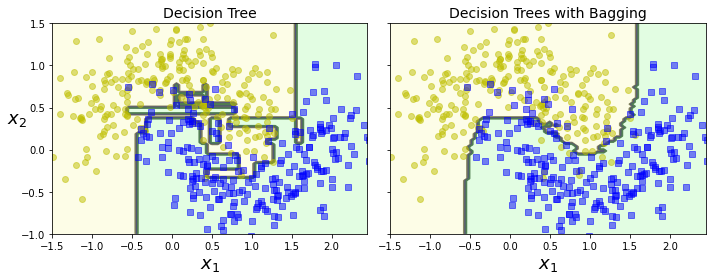

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [ ]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# Random Forests

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Rừng Ngẫu nhiên gồm nhiều cây quyết định:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

## Feature Importance

*Dùng MNIST datasets*

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [ ]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

Hình sau bao phủ các ranh giới quyết định của 15 cây quyết định. Có thể thấy, mặc dù mỗi cây quyết định có dự đoán không tốt lắm, nhưng tập hợp chúng lại cho ra dự đoán tốt hơn nhiều

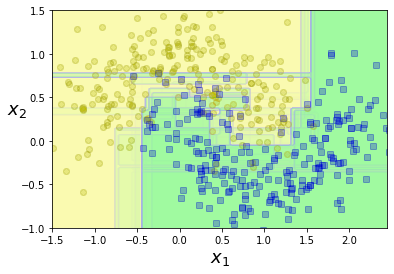

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**Tầm quan trọng của pixel MNIST (theo bộ phân loại Random Forest):**

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


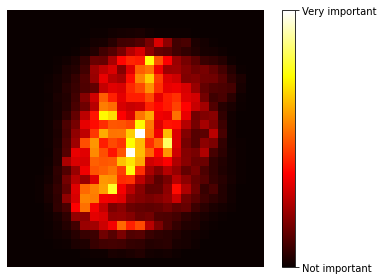

In [ ]:
import matplotlib as mpl

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting
## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

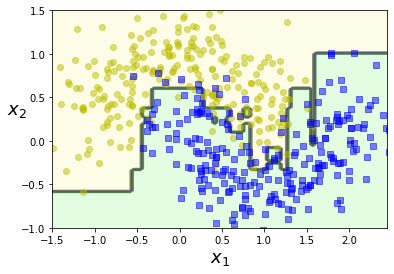

In [ ]:
plot_decision_boundary(ada_clf, X, y)

**Ranh giới quyết định của các yếu tố dự đoán liên tiếp :**

Saving figure boosting_plot


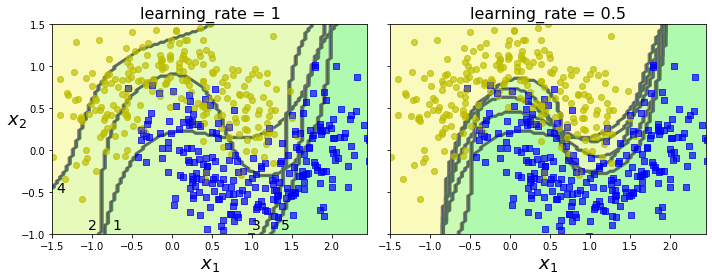

In [ ]:
m = len(X_train)
from sklearn.svm import SVC

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

## Gradient Boosting

Tạo quadratic dataset :

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

 Train một bộ hồi quy cây quyết định trên tập dữ liệu này:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

array([0.75026781])

**Bộ dự đoán đầu tiên (trên cùng bên trái) được huấn luyện bình thường, sau đó mỗi bộ dự đoán liên tiếp (giữa bên trái và dưới bên trái) được huấn luyện dựa trên phần dư của bộ dự đoán trước đó; cột bên phải hiển thị các dự đoán của nhóm kết quả:**

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


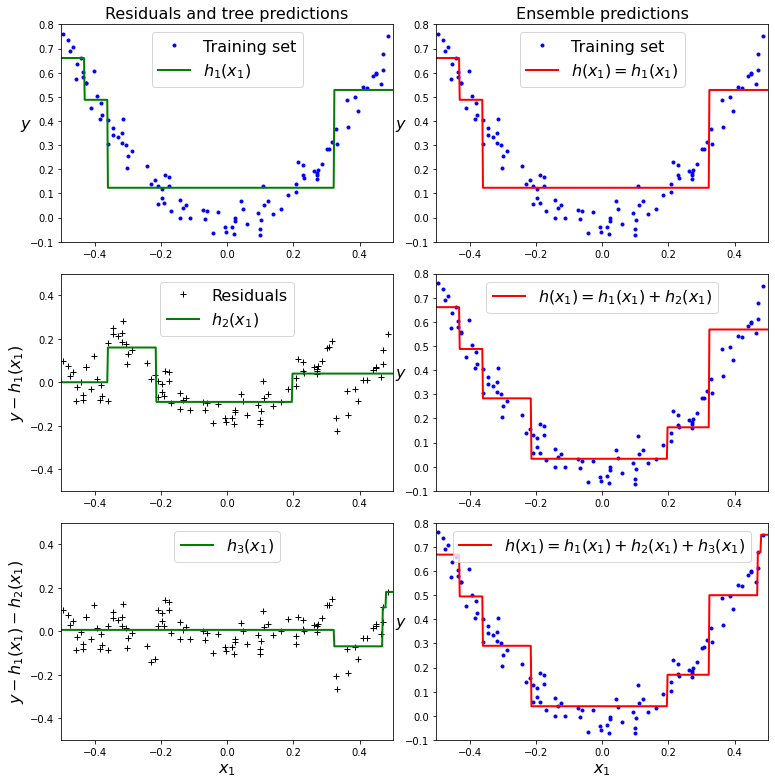

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Bây giờ chúng ta hãy thử một bộ hồi quy tăng cường độ dốc:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**GBRT tập hợp không đủ yếu tố dự đoán (trái) và quá nhiều (phải):**

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


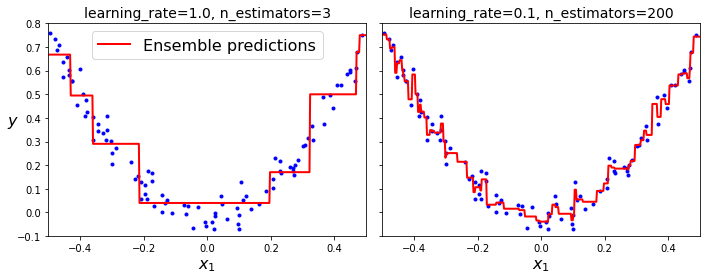

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**Gradient Boosting với Early Stopping :**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

**Điều chỉnh số lượng cây bằng cách sử dụng Early Stopping :**

In [ ]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


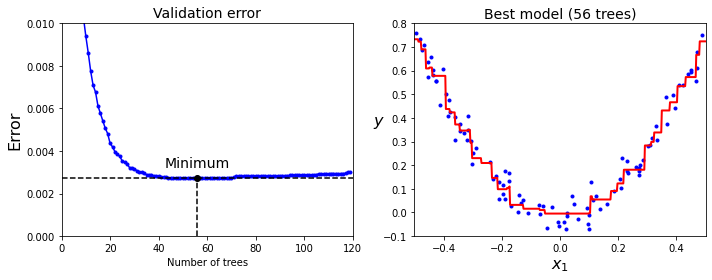

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

Early stopping muộn hơn một chút (chỉ ngắt training nếu không có cải thiện trong 5 epochs):

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

61


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**Dùng XGBoost:**

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

[03:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 33.2 ms per loop


## 8. Voting Classifier

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9639]

Linear SVM vượt xa các classifier khác. Tuy nhiên, hãy giữ nó lại vì nó có thể cải thiện hiệu suất của bộ phân loại

Tiếp theo, hãy cố gắng kết hợp chúng thành một tập hợp hoạt động tốt hơn tất cả chúng trên tập hợp xác thực, sử dụng bộ phân loại biểu quyết mềm hoặc cứng.

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.score(X_val, y_val)

0.9708

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9639]

Hãy xóa SVM để xem liệu hiệu suất có được cải thiện hay không. Có thể xóa công cụ ước tính bằng cách đặt nó thành `None` sử dụng `set_params()` như sau:

In [ ]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

Cập nhật danh sách bộ dự đoán

In [ ]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

Tuy nhiên, nó không cập nhật danh sách các bộ dự đoán _trained_ :

In [ ]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

Vì vậy, ta có thể điều chỉnh lại `VotingClassifier` hoặc chỉ cần xóa SVM khỏi danh sách các công cụ ước tính được train:

In [ ]:
del voting_clf.estimators_[2]

Giờ tính lại `VotingClassifier` : 

In [ ]:
voting_clf.score(X_val, y_val)

0.9736

Tốt hơn một chút! SVM đã làm giảm hiệu suất. Bây giờ, thử sử dụng bộ phân loại biểu quyết mềm. Thực sự thì không cần phải train lại classifier vì ta có thể đặt từ `voting` sang `"soft"`:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

0.97

Không, biểu quyết cứng thắng trong trường hợp này

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9704

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9604]

Voting classifier chỉ làm giảm một chút tỷ lệ lỗi của mô hình tốt nhất trong trường hợp này

## 9. Stacking Ensemble

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.9684

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.9671

Nhóm xếp chồng này không hoạt động tốt như Voting Classifier mà chúng tôi đã đào tạo trước đó, nó không hoàn toàn tốt bằng bộ classifier cá nhân tốt nhất.